In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re

import warnings
warnings.filterwarnings("ignore")

the dataset contains THREE YEARS of recorded incidents ("alarms") of broken fridges with some specific infos:
* When the fridge breaks down this is reported in the computer system and the CMS company sends an ingeneer to fix it and they it asks the Supermarket to pay for the service (maybe its a good business in Colombia ;)
* the original file has 150MB
* 600.000 records from 2012-2015

The questions are:
* If the company has details (data, logs etc) on all the "alarms" in the year 2012 - 2015, it wants to predicts how many alarms in each store in each month will happen in 2016?
* why?
* which shops has largest smallest number of alarms (maybe normalize per size of the shop)
* what data would you suggest the manager to collect to make the dataser more complete
* report and ask questions

Lets look at the data
* Work Order Number ----------------------------------------- 12939001 (like a factura, work done was stored as a number)
* Site Number -------------------------------------------------- A0052 (each store that company maintains has a number)
* Site Type ---------------------------------------------- SUPERMARKET (type of store: Supermarket(big)/Convenience(small))
* Date Created -------------------------------------- 02/02/2012 09:45 (date and time that the alarm occured)
* Date Completed  ----------------------------------- 02/02/2012 21:10 (date and time that the alarm was silenced)
* Provider Name  ------------------------------- CMS Solutions Limited (name of the maintenance company)
* WO Current Status ---------------------------------------------- EOL (I dont remember)
* Asset Category --------------------------------------- REFRIGERATION (type of asset, they also fix aircond, light etc)
* Problem Type Name ---------- Fixture Critical Over Temperature Alarm (type of alarm)
* Requested By ---------------------------- Urgent Refrigeration Alarm (priority of the alarm)
* WO Priority ------------------------------------------- Standard SLA (for accountancy of the company)
* Manufacturer ---------------------------------------------- LINDE AG (manufacturer of the asset that made the alarm)
* Asset In-Service Date ----------------------------- 23/05/2012 05:00 (when the machine was first connected)
* Level 1 Organization Name ------------------------------- Region S01 (the company divied the country into regions)
* Site Zipcode ----------------------------------------------- CR0 4XT (postal code of the store - helps to locate it)
* Sales Sq. Ft. ---------------------------------------------- 48409.0 (the size of the stor in square feet)
* Asset Barcode ------------------------------------------ SSL00319496 (number of the assed (fridge), a label)
* Client Product Name -------------------------------------------- NaN (dont remember)
* Asset Type ---------------------------------------- REMOTE MULTIDECK (fridge can be open, closed, cabinet etc)
* Asset Status ---------------------------------------------- Inactive (is the asset active today -time of generating dataset)

In [2]:
data = pd.read_csv("./data/datacll.csv")

In [3]:
%%time
data["date_created"] = pd.DatetimeIndex(data.date_created)
data["date_completed"] = pd.DatetimeIndex(data.date_completed)
data["asset_in_service_date"] = pd.DatetimeIndex(data.asset_in_service_date)

CPU times: total: 609 ms
Wall time: 966 ms


In [4]:
data.head(3)

,preserves,work_order_number,site_number,site_type,date_created,date_completed,provider_name,wo_current_status,asset_category,problem_type_name,requested_by,wo_priority,manufacturer,asset_in_service_date,level_1_organization_name,site_zipcode,sales_sq_ft,asset_barcode,asset_type,asset_status
0,Frozen Food,12904684,A0892,SUPERMARKET,2012-01-02 03:05:00,2012-01-02 10:00:00,Space Engineering services LTD,EOL,REFRIGERATION,Fixture Critical Over Temperature Alarm,Urgent Refrigeration Alarm,Standard SLA,CARTER,2011-01-06 15:19:00,Region N10,DN31 1UF,42639.0,SSL00567391,HALF GLASS DOOR & WELL,In Service
1,Frozen Food,12904685,A0892,SUPERMARKET,2012-01-02 03:05:00,2012-01-02 09:59:00,Space Engineering services LTD,EOL,REFRIGERATION,Fixture Critical Over Temperature Alarm,Urgent Refrigeration Alarm,Standard SLA,CARTER,2011-01-06 15:19:00,Region N10,DN31 1UF,42639.0,SSL00567398,FULL GLASS DOOR,In Service
2,Frozen Food,12904853,A0892,SUPERMARKET,2012-01-02 05:10:00,2012-01-02 10:01:00,Space Engineering services LTD,EOL,REFRIGERATION,Fixture Critical Over Temperature Alarm,Urgent Refrigeration Alarm,Standard SLA,CARTER,2011-01-06 15:19:00,Region N10,DN31 1UF,42639.0,SSL00567399,FULL GLASS DOOR,In Service


# Prueba para observar tendencia del conteo de alarmas para cada mes en cada año
En total deben ser 12 meses en 4 años -> 48 puntos

In [5]:
data_prueba = data.date_created.dt.to_period('M').value_counts().reset_index()
data_prueba.columns = ["month_year","count_date"]
data_prueba = data_prueba.sort_values(by=['month_year'])

In [6]:
data_prueba["m_y_number"] = range(48) # Se asigna valores numericos unicos para cada valor de la columna "month_year" para graficar

In [7]:
data_prueba.head()

,month_year,count_date,m_y_number
47,2012-01,2684,0
44,2012-02,4783,1
40,2012-03,6833,2
43,2012-04,5467,3
14,2012-05,12312,4


In [8]:
dates_list = data_prueba.month_year.astype(str).tolist() # almacena lista de meses en formato string (inicialmente estan en formato Period[M])

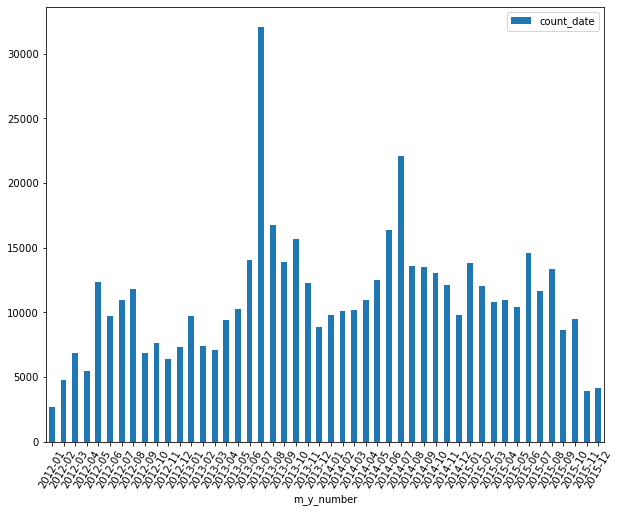

In [9]:
data_prueba.plot(x="m_y_number",y="count_date", kind="bar",figsize=(10,8))
plt.xticks(range(48),dates_list,rotation=60)
plt.show()

## Continuando Analisis con dataset original

In [10]:
data.insert(5,"month_year",data.date_created.dt.to_period('M')) # crea columna "month_year"

In [11]:
data.head(3)

,preserves,work_order_number,site_number,site_type,date_created,month_year,date_completed,provider_name,wo_current_status,asset_category,...,requested_by,wo_priority,manufacturer,asset_in_service_date,level_1_organization_name,site_zipcode,sales_sq_ft,asset_barcode,asset_type,asset_status
0,Frozen Food,12904684,A0892,SUPERMARKET,2012-01-02 03:05:00,2012-01,2012-01-02 10:00:00,Space Engineering services LTD,EOL,REFRIGERATION,...,Urgent Refrigeration Alarm,Standard SLA,CARTER,2011-01-06 15:19:00,Region N10,DN31 1UF,42639.0,SSL00567391,HALF GLASS DOOR & WELL,In Service
1,Frozen Food,12904685,A0892,SUPERMARKET,2012-01-02 03:05:00,2012-01,2012-01-02 09:59:00,Space Engineering services LTD,EOL,REFRIGERATION,...,Urgent Refrigeration Alarm,Standard SLA,CARTER,2011-01-06 15:19:00,Region N10,DN31 1UF,42639.0,SSL00567398,FULL GLASS DOOR,In Service
2,Frozen Food,12904853,A0892,SUPERMARKET,2012-01-02 05:10:00,2012-01,2012-01-02 10:01:00,Space Engineering services LTD,EOL,REFRIGERATION,...,Urgent Refrigeration Alarm,Standard SLA,CARTER,2011-01-06 15:19:00,Region N10,DN31 1UF,42639.0,SSL00567399,FULL GLASS DOOR,In Service


In [12]:
data = data.merge(data_prueba, how='left', on='month_year') # Agrupa resultados del conteo de alarmas para cada mes

In [13]:
data.drop("m_y_number",axis=1,inplace=True) # elimina columna innecesaria al agrupar llamada "m_y_number"
data.head()


,preserves,work_order_number,site_number,site_type,date_created,month_year,date_completed,provider_name,wo_current_status,asset_category,...,wo_priority,manufacturer,asset_in_service_date,level_1_organization_name,site_zipcode,sales_sq_ft,asset_barcode,asset_type,asset_status,count_date
0,Frozen Food,12904684,A0892,SUPERMARKET,2012-01-02 03:05:00,2012-01,2012-01-02 10:00:00,Space Engineering services LTD,EOL,REFRIGERATION,...,Standard SLA,CARTER,2011-01-06 15:19:00,Region N10,DN31 1UF,42639.0,SSL00567391,HALF GLASS DOOR & WELL,In Service,2684
1,Frozen Food,12904685,A0892,SUPERMARKET,2012-01-02 03:05:00,2012-01,2012-01-02 09:59:00,Space Engineering services LTD,EOL,REFRIGERATION,...,Standard SLA,CARTER,2011-01-06 15:19:00,Region N10,DN31 1UF,42639.0,SSL00567398,FULL GLASS DOOR,In Service,2684
2,Frozen Food,12904853,A0892,SUPERMARKET,2012-01-02 05:10:00,2012-01,2012-01-02 10:01:00,Space Engineering services LTD,EOL,REFRIGERATION,...,Standard SLA,CARTER,2011-01-06 15:19:00,Region N10,DN31 1UF,42639.0,SSL00567399,FULL GLASS DOOR,In Service,2684
3,"Meat, Fish and Poultry",12927899,A0416,SUPERMARKET,2012-01-02 08:40:00,2012-01,2012-02-02 13:03:00,CMS Solutions Limited,EOL,REFRIGERATION,...,Standard SLA,LINDE,2002-01-08 05:00:00,Region S01,BR4 0PU,13423.0,SSL00225160,REMOTE MULTIDECK,In Service,2684
4,Frozen Food,12932231,A0003,SUPERMARKET,2012-01-02 13:33:00,2012-01,2012-08-02 19:39:00,CMS Solutions Limited,EOL,REFRIGERATION,...,Standard SLA,RADFORD RETAIL SYSTEMS,2009-03-15 04:00:00,Region S02,DA11 8JH,37870.0,SSL00583503,FULL GLASS DOOR,Scrapped,2684


In [14]:
data.to_csv("./data/d_cll.csv",index=None) # Se guardan los resultados para un posterior analisis usando la columna "count_date"

# ¿Cuantas alarmas ocurriran en el 2016 en cada tienda?
#### Se puede responder considerando cuando ocurre la alarma, es decir que la variable predictora (target) debe ser creada a partir de la columna que indica la fecha en que la alarma se activo "date_created" y el resto de variables deben ser parametros caracteristicos (labels)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527644 entries, 0 to 527643
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   preserves                  527644 non-null  object        
 1   work_order_number          527644 non-null  int64         
 2   site_number                527644 non-null  object        
 3   site_type                  527644 non-null  object        
 4   date_created               527644 non-null  datetime64[ns]
 5   month_year                 527644 non-null  period[M]     
 6   date_completed             527644 non-null  datetime64[ns]
 7   provider_name              527644 non-null  object        
 8   wo_current_status          527644 non-null  object        
 9   asset_category             527644 non-null  object        
 10  problem_type_name          527644 non-null  object        
 11  requested_by               527644 non-null  object  

Seleccionamos las columnas que pueden servir para un primer modelo.
* predictora (target): count_date
* labels:
    * site_type (categorical)
    * date_completed (datetime)
    * provider_name (categorical)
    * asset_category (categorical)
    * problem_type_name (categorical)
    * requested_by (categorical)
    * wo_priority (categorical)
    * manufacturer (categorical) 
    * asset_in_service_date (datetime)
    * sales_sq_ft (categorical)
    * asset_type (float)
    * asset_status (categorical)
    * cooling_range (categorical)
    * preserves (categorical)

#### Convertir variables categoricas a numericas para implementarlas

In [16]:
target = data["count_date"]

In [17]:
data_filtered = data[["count_date","site_type","date_created","date_completed","provider_name","asset_category","problem_type_name",
               "requested_by","wo_priority","manufacturer","asset_in_service_date","sales_sq_ft",
               "asset_type","asset_status","preserves"]]
data_filtered.head()

,count_date,site_type,date_created,date_completed,provider_name,asset_category,problem_type_name,requested_by,wo_priority,manufacturer,asset_in_service_date,sales_sq_ft,asset_type,asset_status,preserves
0,2684,SUPERMARKET,2012-01-02 03:05:00,2012-01-02 10:00:00,Space Engineering services LTD,REFRIGERATION,Fixture Critical Over Temperature Alarm,Urgent Refrigeration Alarm,Standard SLA,CARTER,2011-01-06 15:19:00,42639.0,HALF GLASS DOOR & WELL,In Service,Frozen Food
1,2684,SUPERMARKET,2012-01-02 03:05:00,2012-01-02 09:59:00,Space Engineering services LTD,REFRIGERATION,Fixture Critical Over Temperature Alarm,Urgent Refrigeration Alarm,Standard SLA,CARTER,2011-01-06 15:19:00,42639.0,FULL GLASS DOOR,In Service,Frozen Food
2,2684,SUPERMARKET,2012-01-02 05:10:00,2012-01-02 10:01:00,Space Engineering services LTD,REFRIGERATION,Fixture Critical Over Temperature Alarm,Urgent Refrigeration Alarm,Standard SLA,CARTER,2011-01-06 15:19:00,42639.0,FULL GLASS DOOR,In Service,Frozen Food
3,2684,SUPERMARKET,2012-01-02 08:40:00,2012-02-02 13:03:00,CMS Solutions Limited,REFRIGERATION,Fixture Critical Over Temperature Alarm,Urgent Refrigeration Alarm,Standard SLA,LINDE,2002-01-08 05:00:00,13423.0,REMOTE MULTIDECK,In Service,"Meat, Fish and Poultry"
4,2684,SUPERMARKET,2012-01-02 13:33:00,2012-08-02 19:39:00,CMS Solutions Limited,REFRIGERATION,Fixture Critical Over Temperature Alarm,Urgent Refrigeration Alarm,Standard SLA,RADFORD RETAIL SYSTEMS,2009-03-15 04:00:00,37870.0,FULL GLASS DOOR,Scrapped,Frozen Food


## Usando factorize.
Si 3 categorias, una columna que lista las categorias en un rango

In [18]:
cat_columns = data_filtered.select_dtypes(['object']).columns # selecciona todas las columnas de tipo "object"
data_filtered[cat_columns] = data_filtered[cat_columns].apply(lambda x: pd.factorize(x)[0]) # utiliza factorize para asignar enteros unicos por categoria
data_filtered.head()

,count_date,site_type,date_created,date_completed,provider_name,asset_category,problem_type_name,requested_by,wo_priority,manufacturer,asset_in_service_date,sales_sq_ft,asset_type,asset_status,preserves
0,2684,0,2012-01-02 03:05:00,2012-01-02 10:00:00,0,0,0,0,0,0,2011-01-06 15:19:00,42639.0,0,0,0
1,2684,0,2012-01-02 03:05:00,2012-01-02 09:59:00,0,0,0,0,0,0,2011-01-06 15:19:00,42639.0,1,0,0
2,2684,0,2012-01-02 05:10:00,2012-01-02 10:01:00,0,0,0,0,0,0,2011-01-06 15:19:00,42639.0,1,0,0
3,2684,0,2012-01-02 08:40:00,2012-02-02 13:03:00,1,0,0,0,0,1,2002-01-08 05:00:00,13423.0,2,0,1
4,2684,0,2012-01-02 13:33:00,2012-08-02 19:39:00,1,0,0,0,0,2,2009-03-15 04:00:00,37870.0,1,1,2


Se convierte fechas en columnas:

In [19]:
data_filtered["date_created_day"] = data_filtered["date_created"].apply(lambda x: x.day)
data_filtered["date_completed_day"] = data_filtered["date_completed"].apply(lambda x: x.day)
data_filtered["asset_in_service_date_day"] = data_filtered["asset_in_service_date"].apply(lambda x: x.day)

In [20]:
data_filtered["date_created_month"] = data_filtered["date_created"].apply(lambda x: x.month)
data_filtered["date_completed_month"] = data_filtered["date_completed"].apply(lambda x: x.month)
data_filtered["asset_in_service_date_month"] = data_filtered["asset_in_service_date"].apply(lambda x: x.month)

In [21]:
data_filtered["date_created_year"] = data_filtered["date_created"].apply(lambda x: x.year)
data_filtered["date_completed_year"] = data_filtered["date_completed"].apply(lambda x: x.year)
data_filtered["asset_in_service_date_year"] = data_filtered["asset_in_service_date"].apply(lambda x: x.year)

In [22]:
data_filtered["date_created_hour"] = data_filtered["date_created"].apply(lambda x: x.hour)
data_filtered["date_completed_hour"] = data_filtered["date_completed"].apply(lambda x: x.hour)
data_filtered["asset_in_service_date_hour"] = data_filtered["asset_in_service_date"].apply(lambda x: x.hour)

In [23]:
data_filtered.drop("date_created",axis=1,inplace=True)
data_filtered.drop("date_completed",axis=1,inplace=True)
data_filtered.drop("asset_in_service_date",axis=1,inplace=True)

In [25]:
data_filtered.head()

,count_date,site_type,provider_name,asset_category,problem_type_name,requested_by,wo_priority,manufacturer,sales_sq_ft,asset_type,...,asset_in_service_date_day,date_created_month,date_completed_month,asset_in_service_date_month,date_created_year,date_completed_year,asset_in_service_date_year,date_created_hour,date_completed_hour,asset_in_service_date_hour
0,2684,0,0,0,0,0,0,0,42639.0,0,...,6,1,1,1,2012,2012,2011,3,10,15
1,2684,0,0,0,0,0,0,0,42639.0,1,...,6,1,1,1,2012,2012,2011,3,9,15
2,2684,0,0,0,0,0,0,0,42639.0,1,...,6,1,1,1,2012,2012,2011,5,10,15
3,2684,0,1,0,0,0,0,1,13423.0,2,...,8,1,2,1,2012,2012,2002,8,13,5
4,2684,0,1,0,0,0,0,2,37870.0,1,...,15,1,8,3,2012,2012,2009,13,19,4


Se observa que es necesario utilizar un Standar Scaler para mantener una coherencia en el resultado

# Primer modelo de regresion
Considerando los 4 años (2012,2013,2014,2015)

In [26]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [27]:
X = data_filtered[data_filtered.columns.tolist()[1:]].to_numpy()
y = data[["count_date"]].to_numpy()

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [29]:
print("Tamaño x entrenamiento:",X_train.shape)
print("Tamaño x prueba:",X_test.shape)
print("Tamaño y entrenamiento:",y_train.shape)
print("Tamaño y prueba:",y_test.shape)

Tamaño x entrenamiento: (422115, 23)
Tamaño x prueba: (105529, 23)
Tamaño y entrenamiento: (422115, 1)
Tamaño y prueba: (105529, 1)


In [30]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [31]:
model = linear_model.LinearRegression()

In [32]:
model.fit(X_train,y_train)

LinearRegression()

In [33]:
y_pred = model.predict(X_test)
 
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Mean squared error: 34529409.43
Variance score: 0.05


In [34]:
y_t = np.reshape(y_test,len(y_test))
y_p = np.reshape(y_pred,len(y_pred))

In [37]:
dicte={"y_test":y_t,"y_pred":np.int32(y_p)}
pd.DataFrame(dicte)

,y_test,y_pred
0,12312,13390
1,5467,10240
2,15652,15461
3,10403,12224
4,32014,14091
...,...,...
105524,13835,13016
105525,13598,13515
105526,10236,11871
105527,9458,13465


# Prediccion 2016

In [38]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527644 entries, 0 to 527643
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   count_date                   527644 non-null  int64  
 1   site_type                    527644 non-null  int64  
 2   provider_name                527644 non-null  int64  
 3   asset_category               527644 non-null  int64  
 4   problem_type_name            527644 non-null  int64  
 5   requested_by                 527644 non-null  int64  
 6   wo_priority                  527644 non-null  int64  
 7   manufacturer                 527644 non-null  int64  
 8   sales_sq_ft                  527644 non-null  float64
 9   asset_type                   527644 non-null  int64  
 10  asset_status                 527644 non-null  int64  
 11  preserves                    527644 non-null  int64  
 12  date_created_day             527644 non-null  int64  
 13 

In [54]:
pred_2016_month = []
month = []
site = []
for i in range(12):
    rand = np.random.randint(0,len(data))
    prueba_2016 = data_filtered.iloc[rand].to_numpy()[1:]
    site.append(data.iloc[rand].to_numpy()[2])
    prueba_2016[15] = i+1
    prueba_2016[18] = 2016.0
    prueba_2016[19] = 2016.0
    prueba_2016 = scaler.transform([prueba_2016])
    pred_2016_month.append(np.int32(model.predict(prueba_2016)))
    if i+1 <= 9: m_t = '0{}'.format(i+1)
    else: m_t = '{}'.format(i+1) 
    month.append('2016-{}'.format(m_t))

In [46]:
y_pred2016 = np.array(pred_2016_month).reshape(-1,12)[0]

In [55]:
dicte={"prediction_2016":y_pred2016,"month":month,"site_number":site}
pd.DataFrame(dicte)

,prediction_2016,month,site_number
0,9231,2016-01,A0852
1,6473,2016-02,A0662
2,6860,2016-03,A0015
3,11884,2016-04,A0019
4,3552,2016-05,A0894
5,10402,2016-06,A0803
6,5047,2016-07,A2143
7,2876,2016-08,A4036
8,10563,2016-09,A0660
9,5074,2016-10,A4103
